In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import jit,njit
from scipy.integrate import solve_ivp
from numba.typed import List
exp=np.exp

@jit
def alpha_m (V):
    return -0.025*(V+40.)/( exp(-(V+40)/10) - 1.0 )
@jit
def beta_m(V):
    return exp(-(V+65)/18)
@jit
def mNa_inf(V):
    return alpha_m(V) / (alpha_m(V) + beta_m(V))
@jit
def tau_mNa(V):
    return 1 / (alpha_m(V) + beta_m(V))/5
@jit
def alpha_h(V):
    return 0.0175*exp(-(V+65)/20)
@jit
def beta_h(V):
    return 0.25/(1.0 + exp(-(V+35)/10) )
@jit
def hNa_inf(V):
    return alpha_h(V) / (alpha_h(V) + beta_h(V))
@jit
def tau_hNa (V):
    return 1 / (alpha_h(V) + beta_h(V))/5
Kdshift=10.0
@jit
def alpha_mKd(V):
    return 0.0025*(V+55.)/(1. - exp(-(V+55.)/10.))

@jit
def beta_mKd(V):
    return 0.03125*exp(-(V+65.)/80.)

@jit
def mKd_inf (V):
    return alpha_mKd(V-Kdshift) / (alpha_mKd(V-Kdshift) + beta_mKd(V-Kdshift))
@jit
def tau_mKd (V):
    return 1 / (alpha_mKd(V-Kdshift) + beta_mKd(V-Kdshift))/5 

@jit
def mA_inf (V):
    return 1/(1+exp(-(V+90)/8.5))
@jit
def tau_mA (V):
    return 0.37 + 1/(exp((V+35.82)/19.697)+exp((V+79.69)/-12.7))/5
@jit
def hA_inf (V):
    return 1/(1+exp((V+78)/6))

@jit
def tau_hA(V): # Inactivation time-constant
    if (V < -63):
        tau_hA = 1/(exp((V+46.05)/5)+exp((V+238.4)/-37.45))
    else:
        tau_hA = 19
    return tau_hA/5

@jit
def mKir_inf (V):
    return 1/(1+exp((V+97.9+10)/9.7))

# T-type Ca-current (mt=activation variable, ht=inactivation variable)
@jit
def mt_inf (V):
    return 1/(1+exp(-(V+57)/6.2)) # Activation function
@jit
def tau_mt (V):
    return 0.612 + 1/(exp(-(V+131.6)/16.7)+exp((V+16.8)/18.2)) # Activation time-constant
@jit
def ht_inf(V):
    return 1/(1+exp((V+81)/4.03))# Inactivation function
@jit
def tau_ht(V): # Inactivation time-constant
    if (V < -80):
        tau_ht = exp((V+467)/66.6)
    else:
        tau_ht = (exp(-(V+21.88)/10.2)+28)
    return tau_ht


# L-type Ca-current (mL=activation variable)
@jit
def mL_inf (V):
    return 1/(1+exp(-(V+55.)/3)) # Activation function
@jit
def tau_mL(V):
    return (72*exp(-(V+45.)**2/400)+6.)# Activation time-constant

# H-current (mH=activation variable)
@jit
def alpha_mH (V):
    return exp(-14.59-(0.086*V))
@jit
def beta_mH (V):
    return exp(-1.87+(0.0701*V))
@jit
def mH_inf (V):
    return  alpha_mH(V) /(alpha_mH(V) + beta_mH(V)) # Activation function
@jit 
def tau_mH (V):
    return 1/(alpha_mH(V) + beta_mH(V)) # Activation time-constant
@jit 
def heaviside (t):
    return (1+np.sign(t))/2
@jit 
def pulse (t,ti,tf):
    return heaviside(t-ti)-heaviside(t-tf)

sin=np.sin
pi=np.pi

@jit 
def Syn_sigm(V):
    rSyn = -45;
    kSyn = 2;
    return 1/(1+exp(-(V-rSyn)/kSyn))
@jit 
def Syn_inf(V,a,b):
    return a*Syn_sigm(V)/(a*Syn_sigm(V)+b)
 
@jit 
def max_abs(a,b):
    if abs(a)>abs(b):
        return a
    else:
        return b
    



In [2]:
@jit
def HM_ODE_element(t,u,p,V_pre):
    # Parameters
    min_num=1e-60
    Iapp=p[0] # Amplitude of constant applied current
    I1=p[1] # Amplitude of first step input
    I2=p[2] # Amplitude of second step input
    ti1=p[3] # Starting time of first step input
    tf1=p[4] # Ending time of first step input
    ti2=p[5] # Starting time of second step input
    tf2=p[6] # Ending time of second step input
    gT=p[7] # T-type calcium current maximal conductance
    gKd=p[8]  # Delayed-rectifier potassium current maximal conductance
    gH=p[9] # H-current maximal conductance
    gNa=p[10] # Sodium current maximal conductance
    gA=p[11] # A-type potassium current maximal conductance
    gKir=p[12]  # Inward-rectifier potassium current maximal conductance
    gLeak=p[13] # Leak current maximal conductance
    gL=p[14] # L-type calcium current maximal conductance
    gKCa=p[15] # Calcium-activated potassium current maximal conductance
    gSyn=p[16] #synaptic conductance
    a=p[17]
    b=p[18]
    C=p[19] # Membrane capacitance
    taunoise=p[21] # Cutoff frequency for low-pass filtered Gaussian noise
    Ain=p[22] # Amplitude of sinusoïdal inut
    Win=p[23] # Frequency of  sinusoïdal inut

    # Variables
    V=u[0] # Membrane potential
    mNa=u[1] # Sodium current activation
    hNa=u[2] # Sodium current inactivation
    mH=u[3] # H current activation
    mt=u[4] # T-type calcium current activation
    ht=u[5] # T-type calcium current inactivation
    mA=u[6] # A-type potassium current activation
    hA=u[7] # A-type potassium current inactivation
    mKd=u[8] # Delayed-rectifier potassium current activation
    mL=u[9] # L-type calcium current activation
    Ca=u[10] # Intracellular calcium concentration
    mSyn = u[11] # synapse
    noise=u[12] # Input noise
    

    # ODEs
    du1=1/C*(- gNa*mNa**3*hNa*(V-VNa) - gH*mH*(V-VH) - gT*mt**2*ht*(V-VCa) - gA*mA**4*hA*(V-VK) - gKd*mKd**4*(V-VK) -
                gKir*mKir_inf(V)*(V-VK) - gLeak*(V-Vleak)- gL*mL*(V-VCa) - gKCa*(Ca/(15.0+Ca))**4*(V-VK) -
                gSyn*mSyn*(V-VSyn) + Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2) + noise + Ain*sin(2*pi*Win*t)) # Voltage equation
    
    du2=1/max_abs(tau_mNa(V),min_num)*(-mNa+mNa_inf(V)) # gating equation
    du3=1/max_abs(tau_hNa(V),min_num)*(-hNa+hNa_inf(V))
    du4=1/max_abs(tau_mH(V),min_num)*(-mH+mH_inf(V))
    du5=1/max_abs(tau_mt(V),min_num)*(-mt+mt_inf(V))
    du6=1/max_abs(tau_ht(V),min_num)*(-ht+ht_inf(V))
    du7=1/max_abs(tau_mA(V),min_num)*(-mA+mA_inf(V))
    du8=1/max_abs(tau_hA(V),min_num)*(-hA+hA_inf(V))
    du9=1/max_abs(tau_mKd(V),min_num)*(-mKd+mKd_inf(V))
    du10=1/max_abs(tau_mL(V),min_num)*(-mL+mL_inf(V))
    du11=(-0.1*(gL*mL*(V-VCa))-0.01*Ca)/4 # Variation of intracellular calcium concentration
    du12=a*Syn_sigm(V_pre)*(1-mSyn)-b*mSyn
    du13=-noise/taunoise # Noise equation
    
    return [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13]

In [3]:
@njit
def  OB_ODE_element(t,u,p,V_pre):
    
    min_num=1e-60
    #it=iter(u)
    #dinamics,Theta,phi,P,u_sys=[[next(it) for _ in range(size)] for size in variable_size]
    
    V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mL,Ca,mSyn,noise=u[0:pos_dinamics]
    
    u_sys=u[pos_p:pos_u_sys]
    P=u[pos_phi:pos_p].reshape(num_phi,num_phi)
    Theta=u[pos_dinamics:pos_Theta]
    phi=u[pos_Theta:pos_phi]
    
    obesV=u_sys[0]
    
    
    Iapp=p[0] # Amplitude of constant applied current
    I1=p[1] # Amplitude of first step input
    I2=p[2] # Amplitude of second step input
    ti1=p[3] # Starting time of first step input
    tf1=p[4] # Ending time of first step input
    ti2=p[5] # Starting time of second step input
    tf2=p[6] # Ending time of second step input
    gT=p[7] # T-type calcium current maximal conductance
    gKd=p[8]  # Delayed-rectifier potassium current maximal conductance
    gH=p[9] # H-current maximal conductance
    gNa=p[10] # Sodium current maximal conductance
    gA=p[11] # A-type potassium current maximal conductance
    gKir=p[12]  # Inward-rectifier potassium current maximal conductance
    gLeak=p[13] # Leak current maximal conductance
    gL=p[14] # L-type calcium current maximal conductance
    gKCa=p[15] # Calcium-activated potassium current maximal conductance
    gSyn=p[16] #synaptic conductance
    a=p[17]
    b=p[18]
    C=p[19] # Membrane capacitance
    taunoise=p[21] # Cutoff frequency for low-pass filtered Gaussian noise
    Ain=p[22] # Amplitude of sinusoïdal inut
    Win=p[23] # Frequency of  sinusoïdal inut

    
    
    PHI0= -mNa**3*hNa*(obesV-VNa) 
    PHI1= -mH*(obesV-VH)
    PHI2= -mt**2*ht*(obesV-VCa)
    PHI3= -mA**4*hA*(obesV-VK)
    PHI4= - mKd**4*(obesV-VK)
    PHI5= -mKir_inf(obesV)*(obesV-VK)
    PHI6= -(obesV-Vleak)
    PHI7= -mL*(obesV-VCa)
    PHI8= -(Ca/(15.0+Ca))**4*(obesV-VK)
    PHI9= -mSyn*(obesV-VSyn)
    Current_in= Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2)+ Ain*sin(2*pi*Win*t)
    
    
    PHI= np.array([PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7,PHI8,PHI9])
    
    #ODEs
    
    du1=1/C*(np.dot(PHI,Theta) + Current_in)+ gamma*(obesV-V)+gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
    
    du2=1/max_abs(tau_mNa(obesV),min_num)*(-mNa+mNa_inf(obesV)) # gating equation
    du3=1/max_abs(tau_hNa(obesV),min_num)*(-hNa+hNa_inf(obesV))
    du4=1/max_abs(tau_mH(obesV),min_num)*(-mH+mH_inf(obesV))
    du5=1/max_abs(tau_mt(obesV),min_num)*(-mt+mt_inf(obesV))
    du6=1/max_abs(tau_ht(obesV),min_num)*(-ht+ht_inf(obesV))
    du7=1/max_abs(tau_mA(obesV),min_num)*(-mA+mA_inf(obesV))
    du8=1/max_abs(tau_hA(obesV),min_num)*(-hA+hA_inf(obesV))
    du9=1/max_abs(tau_mKd(obesV),min_num)*(-mKd+mKd_inf(obesV))
    du10=1/max_abs(tau_mL(obesV),min_num)*(-mL+mL_inf(obesV))
    du11=(-0.1*(gL*mL*(obesV-VCa))-0.01*Ca)/4 # Variation of intracellular calcium concentration
    du12=a*Syn_sigm(V_pre)*(1-mSyn)-b*mSyn
    du13=-noise/taunoise # Noise equation
    
    du14=gamma_mask*np.dot(P,phi)*(obesV-V)
    
    du15=mask*(-gamma*phi+PHI)
    #du14=(np.absolute(du14)>min_num)*du14
    
    du16=alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)
    
    du17=HM_ODE_element(t,u_sys,p,V_pre)
    
    
    return [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13], du14 ,du15,du16.flatten(),du17



In [4]:
def OB_ODE(t,u):
    return OB_ODE2_element(t,u,p,0)

In [5]:
@jit
def HM_ODE(t,u):
    return HM_ODE_element(t,u,p,0)

In [6]:
def HCO(t,u):
    neuron1= HM_ODE_element(t,np.array(u[:13]),p1,u[13])
    neuron2= HM_ODE_element(t,np.array(u[13:]),p2,u[0])
    return [*neuron1,*neuron2]

In [7]:
def three_neurons(t,u):
    neuron1= HM_ODE_element(t,u[:13],p1,u[13])
    neuron2= HM_ODE_element(t,u[13:26],p2,u[26])
    neuron3= HM_ODE_element(t,u[26:],p3,u[0])
    return neuron1+neuron2+neuron3

In [8]:
def three_neurons_OB(t,u):
    a,b,c,d,e= OB_ODE_element(t,np.array(u[:num_parameter]),p1,u[num_parameter+pos_p])
    neuron1=[*a,*b,*c,*d,*e]
    a,b,c,d,e= OB_ODE_element(t,np.array(u[num_parameter:num_parameter*2]),p2,u[num_parameter*2+pos_p])
    neuron2=[*a,*b,*c,*d,*e]
    a,b,c,d,e= OB_ODE_element(t,np.array(u[num_parameter*2:]),p2,u[pos_p])
    neuron3=[*a,*b,*c,*d,*e]
    return [*neuron1,*neuron2,*neuron3]

In [9]:
def four_neurons(t,u):
    neuron1= HM_ODE_element(t,u[:13],p1,u[13])
    neuron2= HM_ODE_element(t,u[13:26],p2,u[26])
    neuron3= HM_ODE_element(t,u[26:39],p3,u[39])
    neuron4= HM_ODE_element(t,u[39:],p4,u[0])
    return neuron1+neuron2+neuron3+neuron4

In [10]:
def five_neurons(t,u):
    neuron1= HM_ODE_element(t,u[:13],p1,u[13])
    neuron2= HM_ODE_element(t,u[13:26],p2,u[26])
    neuron3= HM_ODE_element(t,u[26:39],p3,u[39])
    neuron4= HM_ODE_element(t,u[39:52],p4,u[52])
    neuron5= HM_ODE_element(t,u[52:],p5,u[0])
    return neuron1+neuron2+neuron3+neuron4+neuron5

In [11]:
def HCO_OB(t,u):
    a,b,c,d,e= OB_ODE_element(t,np.array(u[:num_parameter]),p1,u[num_parameter+num_dinamics+num_Theta+num_phi+num_p])
    neuron1=[*a,*b,*c,*d,*e]
    a,b,c,d,e= OB_ODE_element(t,np.array(u[num_parameter:]),p2,u[num_dinamics+num_Theta+num_phi+num_p])
    neuron2=[*a,*b,*c,*d,*e]
    return [*neuron1,*neuron2]

In [12]:
num_dinamics=13
num_Theta=10
num_phi=num_Theta
num_p=num_Theta**2
num_u_sys=13
num_parameter=num_dinamics+num_Theta+num_phi+num_p+num_u_sys
model_output=num_dinamics+num_Theta+num_phi+num_p+1
variable_size=[num_dinamics,num_Theta,num_phi,num_p,num_u_sys]

pos_dinamics=num_dinamics
pos_Theta=pos_dinamics+num_Theta
pos_phi=pos_Theta+num_phi
pos_p=pos_phi+num_p
pos_u_sys=pos_p+num_u_sys

In [13]:
#Test real model
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 50.; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -80.; # Potassium reversal potential -90
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
Vleak = -49.; # Reversal potential of leak channels
VSyn=-120.

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance
gNa=120.; # Sodium current maximal conductance
gKd=30.; # Delayed-rectifier potassium current maximal conductance
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance
gT=2.; # T-type calcium current maximal conductance
gH=0.1; # H-current maximal conductance
gL=0.4; # L-type calcium current maximal conductance
gKCa=2.; # Calcium-activated potassium current maximal conductance
gSyn=4.0
a=2.0
b=0.1
## Definition of simulation time.
Tfinal=6000.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=-4.0

# Current pulses
I1=0. # Amplitude of first pulse
ti1=0. # Starting time of first pulse
tf1=100.0 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=50.0 # Starting time of second pulse
tf2=150.0 # Ending time of first pulse

# Sinusoidal input
Ain=0.0 # Amplitude
Win=0.5 # Frequency

# Input noise
NoiseIN=0.0 # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,2.5,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,a,b,C,NoiseIN,TauNoise,Ain,Win]
p1 = List()
[p1.append(x) for x in p]
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,a,b,C,NoiseIN,TauNoise,Ain,Win]
p2 = List()
[p2.append(x) for x in p]
# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b), 0.0]
V0= -63.
x1 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b), 0.0]
X0= [*x0,*x1]


In [14]:
start = time.time()
sol=solve_ivp(HCO ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 19.929473161697388


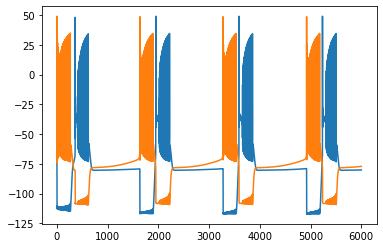

In [15]:
plt.plot(sol.t, sol.y[13])
plt.plot(sol.t, sol.y[0])

In [440]:
#Test real model 3 neurons
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 50.; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -80.; # Potassium reversal potential -90
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
Vleak = -49.; # Reversal potential of leak channels
VSyn=-120.

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance
gNa=120.; # Sodium current maximal conductance
gKd=30.; # Delayed-rectifier potassium current maximal conductance
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance
gT=2.; # T-type calcium current maximal conductance
gH=0.1; # H-current maximal conductance
gL=0.4; # L-type calcium current maximal conductance
gKCa=2.; # Calcium-activated potassium current maximal conductance
gSyn=4.0
a=2.0
b=0.1
## Definition of simulation time.
Tfinal=6000.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=-4.0

# Current pulses
I1=0. # Amplitude of first pulse
ti1=0. # Starting time of first pulse
tf1=100.0 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=50.0 # Starting time of second pulse
tf2=150.0 # Ending time of first pulse

# Sinusoidal input
Ain=0.0 # Amplitude
Win=0.5 # Frequency

# Input noise
NoiseIN=0.0 # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,2.5,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,a,b,C,NoiseIN,TauNoise,Ain,Win]
p1 = List()
[p1.append(x) for x in p]
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,a,b,C,NoiseIN,TauNoise,Ain,Win]
p2 = List()
[p2.append(x) for x in p]
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,a,b,C,NoiseIN,TauNoise,Ain,Win]
p3 = List()
[p3.append(x) for x in p]
# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b), 0.0]
V0= -63.
x1 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b), 0.0]
V0= -60.
x2 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b), 0.0]

X0= [*x0,*x1,*x2]


In [441]:
start = time.time()
sol=solve_ivp( three_neurons ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 27.245020151138306


C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


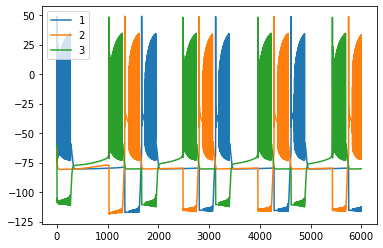

In [443]:
plt.plot(sol.t, sol.y[0],label='1')
plt.plot(sol.t, sol.y[13],label='2')
plt.plot(sol.t, sol.y[26],label='3')
plt.legend()
plt.show()

In [448]:
p4=p3
X0=[*x0,*x1,*x2,*x2]
start = time.time()
sol=solve_ivp( four_neurons ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 39.569822549819946


C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


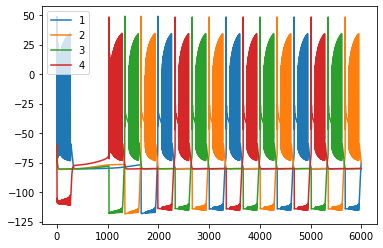

In [449]:
plt.plot(sol.t, sol.y[0],label='1')
plt.plot(sol.t, sol.y[13],label='2')
plt.plot(sol.t, sol.y[26],label='3')
plt.plot(sol.t, sol.y[39],label='4')
plt.legend()
plt.show()

In [454]:
p5=p2
X0=[*x0,*x1,*x2,*x2,*x1]
start = time.time()
sol=solve_ivp( five_neurons ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 50.068310022354126


C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


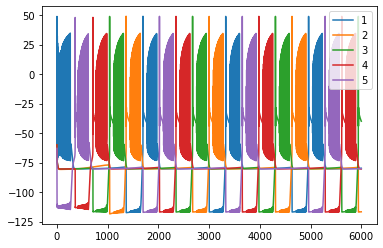

In [455]:
plt.plot(sol.t, sol.y[0],label='1')
plt.plot(sol.t, sol.y[13],label='2')
plt.plot(sol.t, sol.y[26],label='3')
plt.plot(sol.t, sol.y[39],label='4')
plt.plot(sol.t, sol.y[52],label='5')
plt.legend()
plt.show()

In [405]:
#Test real model
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 50.; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -80.; # Potassium reversal potential -90
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
Vleak = -49.; # Reversal potential of leak channels
VSyn=-120.

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance
gNa=120.; # Sodium current maximal conductance
gKd=30.; # Delayed-rectifier potassium current maximal conductance
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance
gT=2.; # T-type calcium current maximal conductance
gH=0.1; # H-current maximal conductance
gL=0.4; # L-type calcium current maximal conductance
gKCa=2.; # Calcium-activated potassium current maximal conductance
gSyn=4. # Synapse maximal conductance
a=2.
b=0.1
## Definition of simulation time.
Tfinal=6000.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=-4.

# Current pulses
I1=0. # Amplitude of first pulse
ti1=0. # Starting time of first pulse
tf1=100. # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=50. # Starting time of second pulse
tf2=150. # Ending time of first pulse

# Sinusoidal input
Ain=0. # Amplitude
Win=0.5 # Frequency

# Input noise
NoiseIN=0.0 # Amplitude
TauNoise=2.0 # Cut-off frequency

#Hyperparameters
gamma=10.
variable_mask=np.array([1,1,1,1,1,1,1,1,1,1])
mask=np.array([1,1,1,1,1,1,1,1,1,1]) #freeze variable by setting 0 in the mask
gamma_mask=mask*gamma
variable_alpha=np.array([1,1,1,1,1,1,1,1,1,1])
alpha=0.01

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,2.5,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,a,b,C,NoiseIN,TauNoise,Ain,Win]
p1 = List()
[p1.append(x) for x in p]
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,a,b,C,NoiseIN,TauNoise,Ain,Win]
p2 = List()
[p2.append(x) for x in p]
# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b), 0.0]
V0= -63.
x1 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b), 0.0]
X0= [*x0,*x1]

Theta0= np.random.rand(num_Theta)*100.
#Theta0[7]=0.4
print(Theta0)
A0=(np.ones(num_Theta)*0.1).tolist()*variable_mask
P0=np.diag(np.diag(np.outer(A0,A0))).flatten().tolist()
#P0[-1]=0
X0_=[*x0,*Theta0,*A0,*P0,*x0,*x1,*Theta0,*A0,*P0,*x1]
print(len(X0_))
print(len(Theta0))

[96.0565998  22.90906118 17.29760195 94.75654013 78.32200701 54.02945184
 94.34875245 64.24719721  7.40176846 23.92017705]
292
10


In [411]:
start = time.time()
sol=solve_ivp(HCO_OB ,tspan , X0_)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))
"Elapsed (with compilation) = 320.12673687934875"
"Elapsed (with compilation) = 60.95720624923706"
"Elapsed (without compilation) = 58.13954496383667"

Elapsed (with compilation) = 58.13954496383667


'Elapsed (with compilation) = 60.95720624923706'

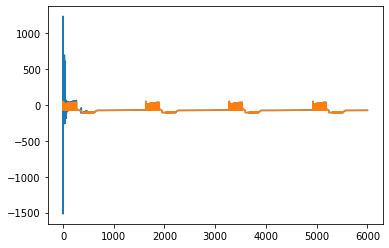

In [412]:
plt.plot(sol.t, sol.y[0])
plt.plot(sol.t, sol.y[num_dinamics+num_Theta+num_phi+num_p])

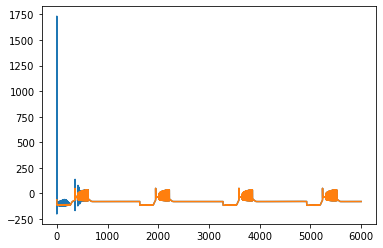

In [413]:
plt.plot(sol.t, sol.y[num_parameter])
plt.plot(sol.t, sol.y[num_parameter+num_dinamics+num_Theta+num_phi+num_p])

C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


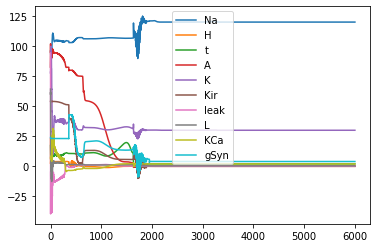

['Na', 'H', 't', 'A', 'K', 'Kir', 'leak', 'L', 'KCa', 'gSyn']
[ 1.20000001e+02  1.00000007e-01  2.00000014e+00 -3.68187068e-08
  3.00000003e+01 -8.61082501e-09  9.99999940e-02  4.00000002e-01
  2.00000002e+00  4.00000002e+00]


In [414]:
#plot parameters
labels=[ 'Na','H','t','A','K','Kir','leak','L','KCa','gSyn']
plt.figure()
for i in range(num_Theta):
    plt.plot(sol.t,sol.y[13+i],label=labels[i])
plt.legend()
plt.show()
print(labels)
print(sol.y[13:13+num_Theta,-1])

C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


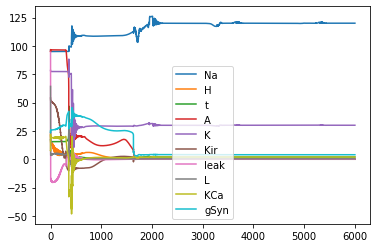

['Na', 'H', 't', 'A', 'K', 'Kir', 'leak', 'L', 'KCa', 'gSyn']
[ 1.19996957e+02  1.00004942e-01  1.99997701e+00 -5.04297465e-05
  2.99992332e+01  1.01437489e-04  9.99991783e-02  4.00000465e-01
  1.99996489e+00  4.00095099e+00]


In [415]:
#plot parameters
labels=[ 'Na','H','t','A','K','Kir','leak','L','KCa','gSyn']
plt.figure()
for i in range(num_Theta):
    plt.plot(sol.t,sol.y[num_parameter+13+i],label=labels[i])
plt.legend()
plt.show()
print(labels)
print(sol.y[num_parameter+13:num_parameter+13+num_Theta,-1])

In [16]:
#Test real model
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 50.; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -80.; # Potassium reversal potential -90
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
Vleak = -49.; # Reversal potential of leak channels
VSyn=-120.

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance
gNa=120.; # Sodium current maximal conductance
gKd=30.; # Delayed-rectifier potassium current maximal conductance
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance
gT=2.; # T-type calcium current maximal conductance
gH=0.1; # H-current maximal conductance
gL=0.4; # L-type calcium current maximal conductance
gKCa=2.; # Calcium-activated potassium current maximal conductance
gSyn=4. # Synapse maximal conductance
a=2.
b=0.1
## Definition of simulation time.
Tfinal=6000.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=-4.

# Current pulses
I1=0. # Amplitude of first pulse
ti1=0. # Starting time of first pulse
tf1=100. # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=50. # Starting time of second pulse
tf2=150. # Ending time of first pulse

# Sinusoidal input
Ain=0. # Amplitude
Win=0.5 # Frequency

# Input noise
NoiseIN=0.0 # Amplitude
TauNoise=2.0 # Cut-off frequency

#Hyperparameters
gamma=10.
variable_mask=np.array([1,1,1,1,1,1,1,1,1,1])
mask=np.array([1,1,1,1,1,1,1,1,1,1]) #freeze variable by setting 0 in the mask
gamma_mask=mask*gamma
variable_alpha=np.array([1,1,1,1,1,1,1,1,1,1])
alpha=0.01

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,2.5,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,a,b,C,NoiseIN,TauNoise,Ain,Win]
p1 = List()
[p1.append(x) for x in p]
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,a,b,C,NoiseIN,TauNoise,Ain,Win]
p2 = List()
[p2.append(x) for x in p]
# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b), 0.0]
V0= -63.
x1 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b), 0.0]
V0= -60.
x2 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b), 0.0]
V0= - np.random.rand(1)*100
x0_ = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b), 0.0]
V0= - np.random.rand(1)*100
x1_ = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b), 0.0]
V0= - np.random.rand(1)*100
x2_ = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b), 0.0]

Theta0= np.random.rand(num_Theta)*100.
#Theta0[7]=0.4
print(Theta0)
A0=(np.ones(num_Theta)*0.1).tolist()*variable_mask
P0=np.diag(np.diag(np.outer(A0,A0))).flatten().tolist()
#P0[-1]=0
X0_=[*x0_,*Theta0,*A0,*P0,*x0,*x1_,*Theta0,*A0,*P0,*x1,*x2_,*Theta0,*A0,*P0,*x2]
print(len(X0_))
print(len(Theta0))

[ 3.80505481 68.81804148 23.28007524 97.02102714 62.53619643 23.32101135
 54.0859228  24.83271512 61.84257801 24.82167899]
438
10


In [17]:
start = time.time()
sol=solve_ivp(three_neurons_OB ,tspan , X0_)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))


Elapsed (with compilation) = 145.2265968322754


C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  
C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


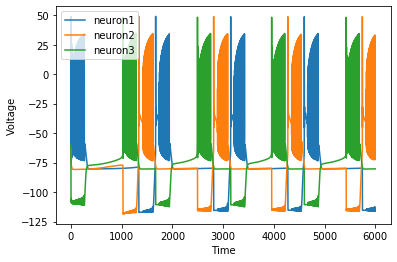

In [30]:
fig=plt.figure()
plt.plot(sol.t, sol.y[pos_p],label='neuron1')
plt.plot(sol.t, sol.y[num_parameter+pos_p],label='neuron2')
plt.plot(sol.t, sol.y[num_parameter*2+pos_p],label='neuron3')
plt.legend()
plt.ylabel('Voltage')
plt.xlabel('Time')
fig.savefig('three_bursting_neurons.jpg')

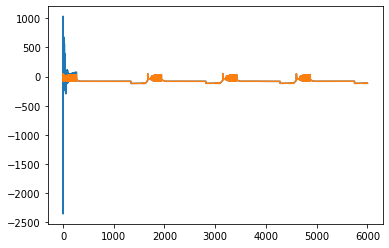

In [19]:
plt.plot(sol.t, sol.y[0])
plt.plot(sol.t, sol.y[pos_p])

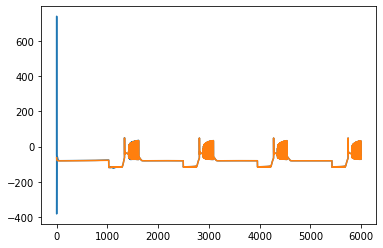

In [20]:
plt.plot(sol.t, sol.y[num_parameter])
plt.plot(sol.t, sol.y[num_parameter+pos_p])

C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  import sys
C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


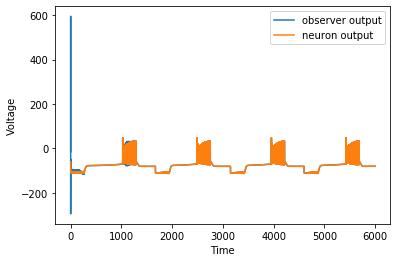

In [31]:
fig=plt.figure()
plt.plot(sol.t, sol.y[num_parameter*2],label='observer output')
plt.plot(sol.t, sol.y[num_parameter*2+pos_p],label='neuron output')
plt.legend()
plt.ylabel('Voltage')
plt.xlabel('Time')
fig.savefig('oneofthree_bursting_neurons.jpg')

C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


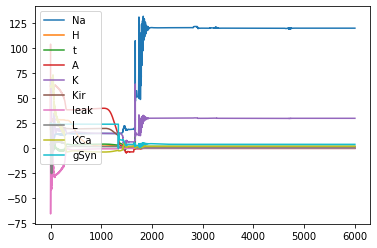

['Na', 'H', 't', 'A', 'K', 'Kir', 'leak', 'L', 'KCa', 'gSyn']
[119.99955149027744 0.09999994582939023 1.9999555244444718
 -2.3742476504254286e-06 29.999840414085053 2.4817306003170352e-09
 0.10000005887082035 0.39999308886163853 2.0000001348589485
 3.9999999131106145]


In [25]:
#plot parameters
labels=[ 'Na','H','t','A','K','Kir','leak','L','KCa','gSyn']
plt.figure()
for i in range(num_Theta):
    plt.plot(sol.t,sol.y[13+i],label=labels[i])
plt.legend()
plt.show()
print(labels)
print(sol.y[13:13+num_Theta,-1])

C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


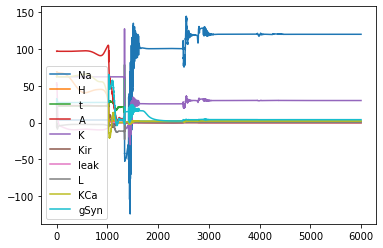

['Na', 'H', 't', 'A', 'K', 'Kir', 'leak', 'L', 'KCa', 'gSyn']
[120.00017440351377 0.10000832440495597 2.0000076206262776
 7.175231163446378e-06 30.000060837938722 1.0581454221053959e-05
 0.09999254742428412 0.4000023757752944 2.0000070469893063
 4.000157799676915]


In [23]:
#plot parameters
labels=[ 'Na','H','t','A','K','Kir','leak','L','KCa','gSyn']
plt.figure()
for i in range(num_Theta):
    plt.plot(sol.t,sol.y[num_parameter+13+i],label=labels[i])
plt.legend()
plt.show()
print(labels)
print(sol.y[num_parameter+13:num_parameter+13+num_Theta,-1])

C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if __name__ == '__main__':


['Na', 'H', 't', 'A', 'K', 'Kir', 'leak', 'L', 'KCa', 'gSyn']
[119.9996649592101 0.0999992373381466 2.000010745454422
 -0.00011974565285896537 29.999914257042246 0.0003027151655631762
 0.1000001638446876 0.3999991706812539 1.9999987220041713
 4.000782546813012]


C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


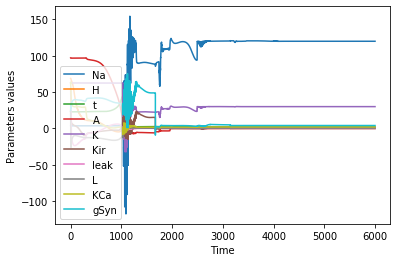

In [29]:
#plot parameters
labels=[ 'Na','H','t','A','K','Kir','leak','L','KCa','gSyn']
fig=plt.figure()
for i in range(num_Theta):
    plt.plot(sol.t,sol.y[num_parameter*2+13+i],label=labels[i])
plt.legend()
plt.ylabel('Parameters values')
plt.xlabel('Time')
fig.savefig('oneofthree_bursting_neurons_parameters.jpg')
print(labels)
print(sol.y[num_parameter*2+13:num_parameter*2+13+num_Theta,-1])